# Thrust Vectoring Analysis

Based on a NASA report - [Optimal Pitch Thrust-Vector Angle and Benefits for all Flight Regimes](https://ntrs.nasa.gov/api/citations/20000034897/downloads/20000034897.pdf)

Use JSBSim to compare how varying the thrust vector angle can minimize fuel
burn for a given flight condition and compare the results to the NASA report.

Tests performed for a cruise condition and for a climb condition.

In [ ]:
# Confirm that JSBSim is installed. If not and running on Google Colab
# then install JSBSim into the Google Colab instance.

import os

try:
  import jsbsim
  print('JSBSim is installed')
  # Relative path to the directory where the flight model is stored
  # Note - Aircraft directory needs to be writeable in order to modify the cg
  PATH_TO_JSBSIM_FILES="../.."
  print(f'Current working directory: {os.getcwd()}')
except ImportError:
  import sys
  if 'google.colab' in sys.modules:
      print('Installing JSBSim...')
      !pip install jsbsim
      # Use the standard aircraft supplied by the JSBSim Python package
      PATH_TO_JSBSIM_FILES=None

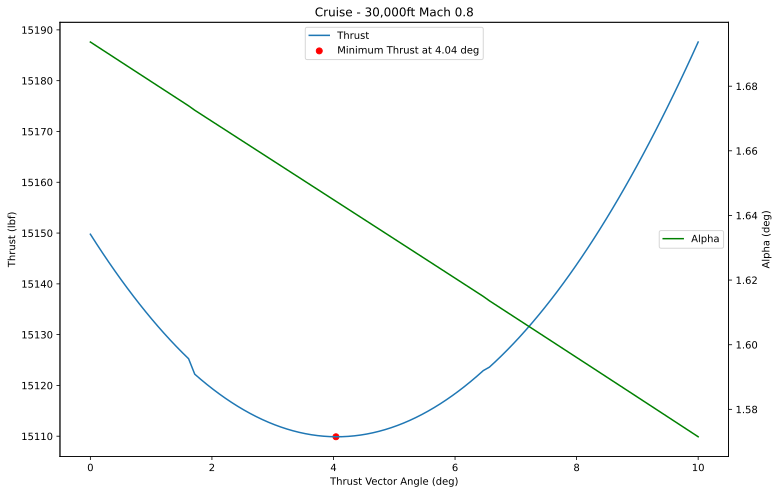

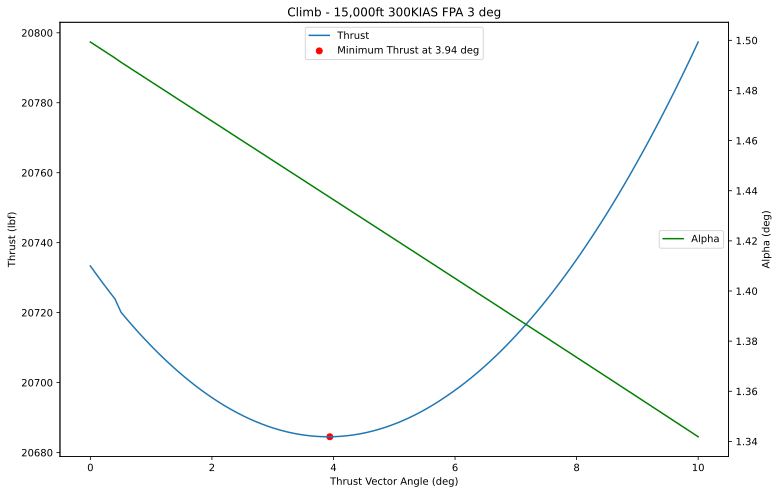

In [ ]:
import jsbsim
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration Section ---
# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="737"

# --- JSBSim Initialization ---
# These lines initialize the flight dynamics model.

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Create a flight dynamics model (FDM) instance.
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1


def thrust_vector_range_test(altitude, speed, flight_path_angle, title):
    # altitude: altitude above sea level (ft)
    # speed: mach number of speed (<1)
    #        calibrated airspeed (kts) (>=1)
    # flight_path_angle: flight path angle (deg)
    # title: title for plot

    # Thrust vectoring angles in pitch (deg) to test
    tv_angles = np.linspace(0, 10, 100)

    # Thrust and AoA trim results storage
    thrusts = []
    alphas = []

    # Initialize the minimum thrust and thrust vectoring angles to a very large number
    # to track/record the minimum thrust and the angle at which the minimum occurs.
    min_thrust = 1000000  # thrust (lbf)
    min_angle = 100       # Thrust Vector Angle in pitch (deg)

    # Iterate each thrust vector angles in pitch.
    for tv_angle in tv_angles:

        # --- Simulation Initialization ---
        # This line initializes the flight dynamics model.

        # Initial conditions
        fdm['ic/h-sl-ft'] = altitude  # altitude above sea level (ft)
        # Check the speed and set the value according to if the speed is mach or kts
        if speed < 1.0:
            fdm['ic/mach'] = speed  # mach number of speed
        else:
            fdm['ic/vc-kts'] = speed # calibrated airspeed (kts)
        fdm['ic/gamma-deg'] = flight_path_angle  # flight path angle (deg)

        # Initialize the aircraft with initial conditions
        fdm.run_ic()


        # --- Simulation running ---
        # These lines run the simulation.

        # Trim the aircraft.
        try:
            # Set thrust vector angle in pitch (deg) for both engines
            fdm["propulsion/engine[0]/pitch-angle-rad"] = math.radians(tv_angle)
            fdm["propulsion/engine[1]/pitch-angle-rad"] = math.radians(tv_angle)

            # Trim the aircraft.
            # 1 means straight flight by using all changeable control variables.
            fdm['simulation/do_simple_trim'] = 1

            # Record the simulation data.
            # Append the angle of attack to the result storage.
            alphas.append(fdm["aero/alpha-deg"])
            # Append the thrust to the result storage.
            thrust = fdm["propulsion/engine[0]/thrust-lbs"]*2  # because there are two engines
            thrusts.append(thrust)

            # Update the minimum thrust and thrust vectoring angles.
            if thrust < min_thrust:
                min_thrust = thrust
                min_angle = tv_angle

        except jsbsim.TrimFailureError:
            print("Trim failed....")
            pass  # Ignore trim failure


    # --- Plot Results ---
    # This section plots the simulation results.

    plt.rcParams["figure.figsize"] = (12, 8)  # Set the figure size for matplotlib plots.
    fig, ax1 = plt.subplots()
    plt.title(title)

    # Plot the thrust values against the thrust vector angles.
    ax1.plot(tv_angles, thrusts, label='Thrust')
    # Plot the minimum thrust as a red scatter point.
    ax1.scatter(min_angle, min_thrust, color='red', label=f'Minimum Thrust at {min_angle:.2f} deg')
    ax1.set_xlabel('Thrust Vector Angle (deg)')
    ax1.set_ylabel('Thrust (lbf)')

    # Create the second y-axis for AoA
    ax2 = ax1.twinx()
    ax2.set_ylabel('Alpha (deg)')
    # Plot the alpha values against the thrust vector angles.
    ax2.plot(tv_angles, alphas, color='green', label='Alpha')

    ax1.legend(loc='upper center')
    ax2.legend(loc='center right')

    # Save the figure as an SVG file.
    plt.savefig(f"{title}.svg", format="svg")

    # Show the plot.
    plt.show()


# Cruise conditions - 30,000ft Mach 0.8
thrust_vector_range_test(30000, 0.8, 0, 'Cruise - 30,000ft Mach 0.8')

# Climb conditions - 15,000ft 300KIAS flight path angle of 3 degrees
thrust_vector_range_test(15000, 300, 3, 'Climb - 15,000ft 300KIAS FPA 3 deg')